In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
import tqdm
from ast import literal_eval
import json
from time import time

# Capture-Correlation

Have seen in 'gaussian_downsampling_test' how both the mean and spread of the distribution of capture efficiency have a strong influence on the way correlations are affected by downsampling.

Want to investigate how the correlation tests perform in these different settings

- Simulate a dataset of samples with a range of interaction strengths
- produce capture efficincy vectors over a grid of mean x spread
- downsample dataset using each capture efficiency
- analyse each dataset using correlation test
- display results

# Simulation

In [2]:
rng = np.random.default_rng(734)

## Code

In [3]:
def gillespie(params, n, tmax=100, ts=10, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialize random generator
    rng = np.random.default_rng()

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Counts")
        plt.legend()
        plt.show()

    return samples

In [4]:
def simulate_dataset(cells, interaction_values):
    '''
    Produce a dataset of pairs of samples simulated with interaction strengths
    given by 'interaction_values' and sample size = cells

    Return count and parameter dataframes
    '''

    # number of pairs
    gene_pairs = len(interaction_values)

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in tqdm.tqdm(range(gene_pairs)):

        # Set reaction rate parameters
        k_tx_1 = 1
        k_tx_2 = 1
        k_deg_1 = 1
        k_deg_2 = 1
        k_reg = interaction_values[i]

        # store parameters
        params_df.iloc[i] = [k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # simulate sample from model
        sample = gillespie(params, cells)

        # store counts
        counts_df.iloc[i] = sample

    return {'params_df': params_df, 'counts_df': counts_df}

In [5]:
def simulate_downsampled_dataset(counts_df, beta):
    '''
    Apply capture efficiency vector 'beta' to produce downsampled dataset using
    the given 'count_df'
    '''

    # get dataset size
    gene_pairs, cells = counts_df.shape

    # error if incomptible cell numbers
    if not (cells == beta.shape[0]):
        print("Incompatible cell numbers")
        return None
    
    # initialize random generator
    rng = np.random.default_rng()

    # setup downsampled dataset
    downsampled_counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    for i in range(gene_pairs):

        # extract counts
        sample = counts_df.iloc[i]
        x1_sample = [x[0] for x in sample]
        x2_sample = [x[1] for x in sample]

        # downsample
        x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
        x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
        sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))
        
        # store counts
        downsampled_counts_df.iloc[i] = sample_downsampled

    return downsampled_counts_df

## Running

In [6]:
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
mean_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
width_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [7]:
# simulate original dataset
datasets = simulate_dataset(
    cells = 1000,
    interaction_values = interaction_values
)

100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


In [8]:
# store data
data_dict = {}

# grid of capture efficiencies
for mean in mean_values:
    for width in width_values:

        # store
        info_dict = {}

        # sample
        # beta = rng.uniform(mean - width, mean + width, size=1000)
        beta = rng.normal(mean, width, size=1000)

        # clamp to [0, 1]
        beta[beta > 1.0] = 1.0
        beta[beta < 0.0] = 0.0

        # store
        info_dict['beta'] = beta

        # downsample dataset
        counts_downsampled = simulate_downsampled_dataset(datasets['counts_df'], beta)

        # store
        info_dict['counts_df'] = counts_downsampled

        # store
        data_dict[(mean, width)] = info_dict

# Correlation tests

## Code

In [9]:
def dataset_analysis_correlation(dataset):
                
    # get dataset shape
    gene_pairs, cells = dataset.shape

    # store results
    corr_result = {}

    # loop over dataset
    for i in range(gene_pairs):

        # select sample
        sample = list(dataset.loc[f'Gene-pair-{i}'])

        # convert string to tuple if neccessary (pandas reading csv to string)
        if type(sample[0]) == str:
            sample = [literal_eval(count_pair) for count_pair in sample]

        # separate pairs into individual samples
        x1_sample = [x[0] for x in sample]
        x2_sample = [x[1] for x in sample]

        # test
        pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')

        # store result
        corr_result[i] = {'pvalue': float(pearson.pvalue), 'statistic': float(pearson.statistic)}

    return corr_result

## Running

In [10]:
# grid of capture efficiencies and datasets
for capture, data in data_dict.items():

    # analyse dataset
    correlation_results = dataset_analysis_correlation(data['counts_df'])

    # store
    data_dict[capture]['correlation'] = correlation_results

    # compute detection threshold
    thresh = None
    for i, res in correlation_results.items():
        if res['pvalue'] > 0.05:
            thresh = interaction_values[i]
            break

    if thresh is None:
        thresh = interaction_values[0]

    data_dict[capture]['threshold'] = thresh

C:\Users\willi\AppData\Local\Temp\ipykernel_23296\1269238967.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')


# Display

In [15]:
# extract threshold info into plottable grid
threshold_array = np.zeros((len(mean_values), len(width_values)))
for i, mean in enumerate(mean_values):
    for j, width in enumerate(width_values):
        threshold_array[i, j] = np.log10(data_dict[(mean, width)]['threshold'])

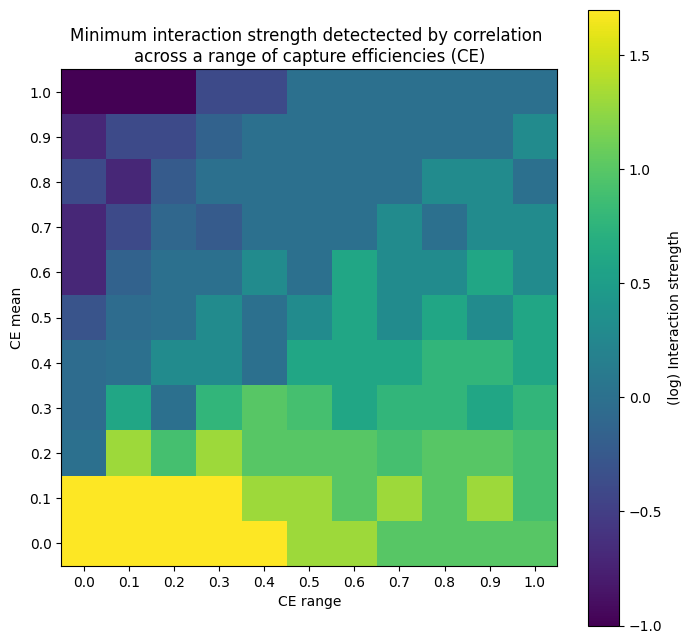

: 

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8))
image = axs.imshow(threshold_array)
axs.set_xlabel("CE range")
axs.set_xticks(range(len(width_values)))
axs.set_xticklabels(width_values)
axs.set_ylabel("CE mean")
axs.set_yticks(range(len(mean_values)))
axs.set_yticklabels(mean_values)
axs.set_title("Minimum interaction strength detectected by correlation \nacross a range of capture efficiencies (CE)")
cbar = plt.colorbar(image, ax=axs)
cbar.set_label("(log) Interaction strength")